<a href="https://colab.research.google.com/github/zrLin4work/Path_Finding/blob/main/ZiranLin_PathPlanning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Task__: Basic Path Planning Implementation

__Methods__:  A*

In this file, I only implement the A* algorithm.

A* algorithm can be seen as an extention of Dijkstra with heuristics. Here, I used following heuristic function:

$$  h(u) = \text{w}(u) + \text{distance}(s, u) + \text{distance}(u, e) + \text{min}\{\text{w}(v)|v \in\text{NextStep}(u) \}  + \text{RestObstacles}(u)$$

where,
- $u$ is current point, $s$ is the start point, $e$ is the end point;
- $\text{w}(u)$ is the weight of point $u$;
- $\text{distance}(\cdot,\cdot)$ calculates the distance between 2 points. It can be chosen according to the task, here, since the agent can only move in 4 directions (up, down, left, right), I used the __Manhattan distance__.
- $\text{min}\{\text{w}(v)|v \in\text{NextStep}(u) \}$ get the minimum cost of all possible next step choices for point $u$, i.e., if we choose point $u$, no matter who is $u$'s successor, its is no smaller than this value.
- $\text{RestObstacles}(u)$ count the rest obstacles in the subgraph that bounded by point $u$ and the end point $e$. More obstacles remain, more likely to detour.


On the other hand, __genetic algorithm__ (GA) can also be used to solve Path Planning Problem, but not so suitable for the specific task.

I tried GA, but since the small scale map and other simple constraints, GA cannot improve the performance.

E.g., in population initialize stage, it's almost impossible to generate a large enough population, i.e., it can only generate a few number of feasible DNA.

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from copy import deepcopy
import shutil
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib import colormaps
INT_INF = 999999999
TEST_ROUND = 0          ## a global counter, use to save the step image.

In [3]:
ROOT = os.getcwd().replace("\\", "/")
if os.path.exists(ROOT+"/steps") == True:
  shutil.rmtree('./steps')
os.mkdir(ROOT+"/steps")

In [4]:
STEP4 = np.array([
    [-1, 0], [1, 0],
    [0, 1], [0, -1]
])
STEP8 = np.array([
    [-1, 0], [1, 0],
    [0, 1], [0, -1],
    [-1, -1], [-1, 1],
    [1, -1], [1, 1]
])


# Predifined Distance Functions

users can choose one of them to calculate the heuristic values, or write their own functions

In [5]:
def Manhattan(source, target, D=1):
    dx = np.abs(source[0] - target[0])
    dy = np.abs(source[1] - target[1])
    return D*(dx+dy)

def Diagonal(source, target, D1=1, D2=2 ** 0.5):
    dx = np.abs(source[0] - target[0])
    dy = np.abs(source[1] - target[1])
    return D1 * (dx + dy) + (D2 - 2 * D1) * min(dx, dy)

def Euclidean(source, target, D=1):
    dx = np.abs(source[0] - target[0])
    dy = np.abs(source[1] - target[1])
    return D * np.sqrt(dx * dx + dy * dy)


# Point - class

the class represents a point in the grid map

contains coordinates and other values that used to choose and track path in A* algorithm

In [6]:
class Point():
    _x = -1
    _y = -1
    _baseDistance = None
    _targetDistance = None
    _parent = None
    _heuristic = None

    def __init__(self, x, y, parent=None, heuristic=None,base_distance=None, target_distance=None):
        self._x = x
        self._y = y
        self._parent = parent
        self._heuristic = heuristic
        self._baseDistance = base_distance
        self._targetDistance = target_distance

    def __str__(self):
        return f"({self._x}, {self._y})"

    def __lt__(self, other):
        if self._heuristic < other._heuristic: return True
        return False

    def __eq__(self, other):
        if self._heuristic == other._heuristic: return True
        return False

    def _le(self, other):
        if self._heuristic <= other._heuristic : return True
        return False

    def __gt__(self, other):
        if self._heuristic > other._heuristic: return True
        return False

    def __ge__(self, other):
        if self._heuristic >= other._heuristic: return True
        return False

    def displayDetails(self):
        st = f'Point ({self._x}, {self._y})'
        if self._parent is not None: st += f'\t|Parent: ({self._parent})'
        if self._heuristic is not None: st += f'\t|Heuristic: ({self._heuristic})'
        print(st)

# Graph - class
the grid map with no weights, i.e., each cell has the same weight/cost

can use Graph.show() to present information

In [7]:
class Graph():
    _col_num = -1
    _row_num = -1
    _map = None
    _start = [0, 0]
    _end = [INT_INF, INT_INF]
    _name = ''
    _waypoints = []
    _obstacles = []

    def __init__(self, col_num:int, row_num:int, start:list=None, end:list=None,
                 blocks:list = [],
                 name="Untitled"):
        """
          Parameter:
            col_num: int. the number of columns of the grid map.
            row_num: int. the number of rows of the grid map.
            start: list|None. the coordinate of start point.
                            if None, use the defualt value, i.e., the left bottom ([0, 0]) of the grid.
            end: list|None. the coordinate of end point.
                            if None, use the defualt value, i.e., the right top ([row_num-1, col_num-1]) of the grid.
            blocks: list. the coordinates of obstacles in the grid. if empty ([]), there is no obstacle.
            name: str. can be used to save the picture. the name of the graph. defualt is "Untitled".
        """
        global TEST_ROUND
        self._col_num = col_num
        self._row_num = row_num
        self._start = start if start is not None else [0,0]
        self._end = end if end is not None else [col_num-1, row_num-1]

        self._obstacles = blocks
        if name == 'Untitled':
            name += str(TEST_ROUND)
            TEST_ROUND += 1

        self._name = name

        self._map = np.ones(shape=(col_num, row_num))
        for [x, y] in blocks:
            self._map[x, y] = INT_INF      ## for blocks, the cost is infinite

    def _color(self, x:int, y:int):
        """
          to get the color of a cell, according to its cost.
          Parameter:
            x: int. the x coordinate of the cell
            y: int. the y coordinate of the cell
        """
        if [x, y] == self._start or [x, y] == self._end:
            ## special for start/end point
            return 'lightgrey'
        elif  self._map[x, y]== INT_INF: return 'dimgray'
            ## obstacles are dark
        else: return 'white'

    def show(self, show_map=False):
        """
          to show some detail information of the graph
          Parameter:
            show_map: boolean. If True, plot the grid map.
        """
        print(f"------ Graph: {self._name} ------\nWidth: {self._col_num}\tHeight: {self._row_num}")

        if show_map == True:
            print("------ Grid Map Matrix ------")
            ax = plt.gca()
            ax.set_xlim((0, self._col_num))
            ax.set_ylim((0,self._row_num))
            mXticks = np.arange(0, self._col_num, 1).astype(int)
            mYticks = np.arange(0, self._row_num, 1).astype(int)
            plt.xticks(mXticks)
            plt.yticks(mYticks)

            for y in range(self._row_num):           # y
                for x in range(self._col_num):       # x
                    rec = plt.Rectangle(
                        (x, y), 1,1, facecolor=self._color(x, y), edgecolor='black')
                    ax.add_patch(rec)

            plt.annotate('S', xy=(self._start[0]+0.5, self._start[1]+0.5))
            plt.annotate('F', xy=(self._end[0]+0.5, self._end[1]+0.5))
            plt.show()

    def cost(self, x, y):
        """
          to get the cost(weight) of a cell. designed for external calls.
          Parameter:
            x: int. the x coordinate of the cell
            y: int. the y coordinate of the cell
        """
        return self._map[x, y]


# WeightedGraph - class

the grid map with weights, i.e., each cell has its own weight/cost

In [23]:
class WeightedGraph(Graph):     ## graph with specific weights for each cell. a sub-class of Graph
    _col_num = -1
    _row_num = -1
    _map = None
    _start = [0, 0]
    _end = [INT_INF, INT_INF]
    _name = ''
    def __init__(self, col_num:int, row_num:int, weights, blocks=[],
                 start = None, end = None,name="Untitled"):
        """
          Parameter:
            col_num: int. the number of columns of the grid map.
            row_num: int. the number of rows of the grid map.
            weights: np.array|list. the weights matrix of the grid.
            start: list|None. the coordinate of start point.
                            if None, use the defualt value, i.e., the left bottom ([0, 0]) of the grid.
            end: list|None. the coordinate of end point.
                            if None, use the defualt value, i.e., the right top ([row_num-1, col_num-1]) of the grid.
            blocks: list. the coordinates of obstacles in the grid. if empty ([]), there is no obstacle.
            name: str. can be used to save the picture. the name of the graph. defualt is "Untitled".
        """
        super().__init__(col_num, row_num, start, end, blocks, name)
        if not isinstance(weights, np.ndarray):
            weights = np.array(weights)
        self._map = weights.astype(int)

        for [x, y] in blocks:
            self._map[x, y] = INT_INF

        # self._map[self._start[0], self._start[1]] = 0
        # self._map[self._end[0], self._end[1]] = 0

        # set a color mapping, from costs to color. Higher weight, darker color.
        items = Counter(weights.reshape(-1))

        # self.color_bar = np.arange(64, 256, step=int((256-64)/len(items)))

        cmap = colormaps.get_cmap('jet')
        cmap.set_under('green')
        cmap.set_over('red')
        self.color_bar = cmap


    def _color(self, i:int):
        """
          get the color according to the cell's weight
          Parameter:
            i: int. the cell's weight
        """
        if i == INT_INF: return 'black'
        # elif i == 0: return 'violet'
        # else: return (1 - self.color_bar[int(i)-1]/256, 1, 1)
        else:
          items = self._map.reshape(-1)
          m, M = min(items), max(items)
          f = (i - m) / (M - m)
          return self.color_bar(f)

    def show(self, show_adj=False):
        print(f"------ Graph: {self._name} ------\nWidth: {self._col_num}\tHeight: {self._row_num}")

        if show_adj == True:
            print("------ Grid Map Matrix ------")

            ax = plt.gca()
            ax.set_xlim((0, self._col_num))
            ax.set_ylim((0,self._row_num))
            mXticks = np.arange(0, self._col_num, 1).astype(int)
            mYticks = np.arange(0, self._row_num, 1).astype(int)
            plt.xticks(mXticks)
            plt.yticks(mYticks)

            for y in range(self._row_num):           # y
                for x in range(self._col_num):       # x

                    if [x, y] == self._start:
                        rec = plt.Rectangle(
                        (x, y), 1,1, facecolor='violet', edgecolor='black')
                        plt.annotate('S', xy=(x + 0.5, y + 0.5))

                    elif [x, y] == self._end:
                        rec = plt.Rectangle(
                        (x, y), 1,1, facecolor='violet', edgecolor='black')
                        plt.annotate('F', xy=(x + 0.5, y + 0.5))

                    else:
                        rec = plt.Rectangle(
                        (x, y), 1,1, facecolor=self._color(self._map[x, y]), edgecolor='black')
                        st = "INF" if self._map[x, y] == INT_INF else str(self._map[x, y])
                        plt.annotate(st, xy=(x + 0.5, y + 0.5))
                    ax.add_patch(rec)
            plt.show()

# AStar - class

Implementation of A* algorithm

In [9]:
class AStar():
    _global_start = None
    _global_end = None

    def __init__(self, graph:Graph|WeightedGraph, varying_terrain:bool=True, direction_num:int=4, distance_function="Manhattan"):

        """
          Parameters:
            graph: Graph|WeightedGraph. the grid map of the task
            varying_terrain: boolean. if True, the grid map has weight matrix.
            direction_num: int.
                            if direction_num == 4: the agent is allowed to move in 4 directions (up, down, left, right)
                            if direction_num == 8: the agent is also allowed to move in diagonal.
            distance_function: string|function.
                            if string, use pre-defined the corresponding distance function.
                            if function, use the user-defined distance function.
        """

        self._G = graph

        ## copy basic information of the map
        self._col_num = graph._col_num
        self._row_num = graph._row_num

        ## the open list and close list
        self._open = []
        self._close = []


        self._varyingTerrain = varying_terrain

        if direction_num == 4:
            self._STEP = STEP4
        elif direction_num == 8:
            self._STEP = STEP8
        else:
            print("We only allow the agent move in 4 or 8 directions! The defualt value is 4.")
            self._STEP = STEP4

        if distance_function == 'Manhattan':
            self._distance = Manhattan
        elif distance_function == 'Diagonal':
            self._distance = Diagonal
        elif distance_function == 'Euclidean':
            self._distance = Euclidean
        else:
            self._distance = distance_function

    def _isOut(self, x, y):
        ## if the point [x, y] out of the map
        if x < 0 or x >= self._col_num or \
            y < 0 or y >= self._row_num:
            return True
        return False

    def _isEnd(self,x, y, end):
        ## if the point [x, y] is the end point
        if [x, y] == end:
            return True
        elif self._global_end is not None:
          if [x, y] == self._global_end:
            return True
        return False

    def _isStart(self, x, y, start):
        ## if the point [x, y] is the start point
        if [x, y] == start:
            return True
        elif self._global_start is not None:
          if [x, y] == self._global_start:
            return True
        return False

    def _isBlock(self, x, y):
        ## if the point [x, y] is a block
        if self._G._map[x, y] == INT_INF:
            # print(f"node ({x}, {y}) is a block")
            return True
        return False

    def _isOpen(self, x, y):
        ## if the point [x, y] is in the open list
        for p in self._open:
            if p._x == x and p._y == y:
                return True
        return False

    def _isClose(self, x, y):
        ## if the point [x, y] is in the close list
        for p in self._close:
            if p._x == x and p._y == y:
                return True
        return False

    def _isAvailabel(self, x, y):
        ## available point should: (1) in the map (2) is not a obstacle
        if self._isOut(x, y) == True or \
            self._isBlock(x, y) == True:
            return False
        return True

    def _nextStep(self, x, y):
        ## generate the candidates of next step.
        ## only return available points
        candidates = self._STEP + [[x, y]] * len(self._STEP)
        availables = []
        for cad in candidates:
            if self._isAvailabel(cad[0], cad[1]) == True:
                availables.append(cad)
        return availables

    def _addToOpenList(self, x, y, parent, start, end, declare=False):
        """
          add point to the open list. the node should be available and not in the openlist
          Parameter:
            x: int. the x coordinate of the point.
            y: int. the y coordinate of the point.
            parent: the parent/previous node of this node, i.e., the agent reach this node from the parent node.
            start: the start point of current task.
            end: the end point of current task.
        """
        baseDist = self._distance([x, y], start)
        targetDist = self._distance([x, y], end)
        cost = self._G.cost(x, y)

        next_steps = self._nextStep(x, y)
        min_next = INT_INF
        for [xx, yy] in next_steps:
            #td = self._distance([xx, yy], end)
            cc = self._G.cost(xx, yy)
            #hh = td + cc
            hh = cc
            if hh < min_next:
              min_next = hh

        x1, x2 = min(x, end[0]), max(x, end[0])
        y1, y2 = min(y, end[1]), max(y, end[1])
        res_obstacle = [
            1 if ((x1 <= ox <= x2 and y1 <= oy <= y2) and ox != x and oy != y) else 0 for [ox, oy] in self._G._obstacles
        ]
        heuristic = cost + baseDist + targetDist + sum(res_obstacle) + min_next


        point = Point(x, y, parent, heuristic, baseDist, targetDist)
        if declare == True: print(f"add node ({x}, {y}) to open list, heuristic value is {cost} + {baseDist} + {targetDist} + {sum(res_obstacle)} + {min_next}= {heuristic}")
        self._open.append(point)

    def _isAvailable(self, x, y):
        # if point [x, y] is available
        if self._isOut(x, y) or self._isBlock(x, y):
            return False
        return True

    def _sortOpenList(self):
        # sort the open list according to their priorities
        if len(self._open) == 0:
            ## if the open list is empty, there is no path
            print('The open list is empty!')
            return
        ## sort by heuristic value at first
            ## for points with the same heuristic value, then sort by the distance to target
                ## then the distance to source point
        new_open = sorted(self._open, key=lambda i: (i, i._targetDistance, i._baseDistance))
        #new_open = sorted(self._open)
        self._open = new_open
        return

    def _processPoint(self, nxt, cur, start, end, ax, stage, save_image=True, declare=False):
        ## process a point, check if it can be explored. if so, add to the open list and plot the picture
        if not self._isAvailable(*nxt):
            return
        if self._isClose(*nxt):
            return
        if not self._isOpen(*nxt):

            self._addToOpenList(nxt[0], nxt[1], cur, start, end, declare)
            ## color the open node
            x, y = nxt[0], nxt[1]
            rec = plt.Rectangle((x, y), 1, 1, facecolor='orange', edgecolor='black',alpha=0.9)
            ax.add_patch(rec)
            if save_image == True: self.SaveImage(stage=stage)

    def buildPath(self, p:Point, ax, start_time, start, stage, declare=False, is_template=False):
        """
          to build a path from current node(usually current termination) to the start
          plot the picture at the same time
          Parameter:
            p: Point. current node.
            ax: plt.axis. the axis to plot the path
            start_time: int. when the algorithem start
            start: Point. the start point of current task
            declare: boolean. if True, print textual information to show the process
        """
        path = []
        x, y = p._x, p._y

        ## start the building loop
        while True:
            if p is None:
                ## current node not exists, break the loop
                break

            ## add current node to the head of the path
            path.insert(0, p)
            if declare == True: print(f"add point [{p._x}, {p._y}] to the path")

            if self._isStart(x, y, start):
                ## come to the start point, break the loop
                break
            else:
                ## hasn't reach the start point, look back upon to the parent point
                # prt = self._findParent(*p._parent)
                prt = p._parent
                p = prt

        if len(path) == 0:
            ## the path is empty, failed
            print("Path building failed!")

        ## loop ended, the path is constructed
        st = 'The chosen path is: \n'
        for p in path[:-1]:
            ## color cells along the path
            rec = plt.Rectangle((p._x, p._y), 1, 1, facecolor='royalblue',edgecolor='black', alpha=0.8)
            ax.add_patch(rec)
            plt.draw()
            st += f"({p._x}, {p._y}) => "

        ## color the end point
        st += f"({path[-1]._x}, {path[-1]._y})"
        rec = plt.Rectangle((path[-1]._x, path[-1]._y), 1, 1, facecolor='royalblue',edgecolor='black', alpha=0.8)
        ax.add_patch(rec)
        plt.draw()
        self.SaveImage(stage=stage)


        print(st)
        if is_template == False:
            end_time = time.time()
            print('===== Algorithm finish in', int(end_time-start_time), ' seconds')
        return path

    def SaveImage(self, stage='Total'):
        graph_name = self._G._name

        millis = int(round(time.time() * 1000))

        filename = ROOT + '/steps/' + graph_name

        if stage == 'Total':
            filename += '_Total_'
        elif isinstance(stage, int):
            filename += f'_Stage-{str(stage)}'
        elif stage is None:
            pass

        filename += "_" + str(millis)[-6:] + '.png'

        plt.savefig(filename)

    def run_without_waypoints(self, start=None, end=None, declare=False, save_step_fig=True, stage=None):
        # os.makedirs('steps')

        if start is None:
            start = self._G._start
        if end is None:
            end = self._G._end

        rows, cols = self._row_num, self._col_num
        # Prepare for draw the process
        _, ax = plt.subplots()
        plt.ylim(0, rows)
        plt.xlim(0, cols)

        mXticks = np.arange(0, cols, 1).astype(int)
        mYticks = np.arange(0, rows, 1).astype(int)
        plt.xticks(mXticks)
        plt.yticks(mYticks)
        ## draw the initial state
        for y in range(rows):
            for x in range(cols):
                if isinstance(self._G, WeightedGraph): color = self._G._color(self._G.cost(x, y))
                elif isinstance(self._G, Graph): color = self._G._color(x, y)
                rec = plt.Rectangle(
                    (x, y), 1,1, facecolor=color, edgecolor='black', alpha=0.5)
                ax.add_patch(rec)
                if [x, y] == start:
                    if stage is None:
                        plt.annotate('S', xy=(start[0]+0.5, start[1]+0.5))
                    else:
                        plt.annotate(f'S({stage})', xy=(start[0]+0.5, start[1]+0.5))
                elif [x, y] == end:
                    if stage is None:
                        plt.annotate('F', xy=(end[0]+0.5, end[1]+0.5))
                    else:
                        plt.annotate(f'F({stage})', xy=(end[0]+0.5, end[1]+0.5))
                elif isinstance(self._G, WeightedGraph):
                    st = "INF" if self._G._map[x, y] == INT_INF else str(self._G._map[x, y])
                    plt.annotate(st, xy=(x + 0.5, y + 0.5))

        # Record the start time
        start_time = time.time()

        start_x, start_y = start[0], start[1]
        self._addToOpenList(start_x, start_y, None, start, end)     ## add the start point to the open list

        while True:
            if len(self._open) == 0:
                ## no points waiting to explore, algorithm ends
                print("No path found! Failed!")
                return []

            ## sort the open list according to estimated cost
            self._sortOpenList()
            ## choose the point with lowest probable cost
            p = deepcopy(self._open[0])

            if declare==True:
              if isinstance(p._parent, Point):
                print(f"choose point [{p._x}, {p._y}], with lowest heuristic value {p._heuristic}, parent is [{p._parent._x}, {p._parent._y}]")
              else:
                print(f"choose point [{p._x}, {p._y}], with lowest heuristic value {p._heuristic}")

            # Reach the end, build path
            if self._isEnd(p._x, p._y, end):
                if stage is None or stage == 'Total':
                    is_template = False
                else:
                    is_template = True
                return self.buildPath(p, ax, start_time, start, stage,declare, is_template)

            # Else, continue the algorithm
            del self._open[0]       # remove current node from the open list
            self._close.append(p)   # add current node into the close list


            candidates = self._nextStep(p._x, p._y)     ## each is available
            for nxt in candidates:
                self._processPoint(nxt, p, start, end, ax, stage=stage, save_image=save_step_fig, declare=declare, )

    def run_with_waypoints(self, waypoints, start=None, end=None,declare=False, save_step_fig=True):
        ## filter out no waypoints situations
        if len(waypoints) == 0:
            return self.run_without_waypoints(start, end, declare, save_step_fig)

        ## initialize the case
        if start is None: start = self._G._start
        if end is None: end = self._G._end

        self._global_start = start
        self._global_end = end

        cur_start = start
        cur_end = None
        # stops = deepcopy(waypoints) + [end]
        stops = deepcopy(waypoints)
        stage = 1
        tmp_paths = []
        start_time = time.time()
        while True:
            self._G._map[self._global_end[0], self._global_end[1]] = INT_INF
            tmp_stops = deepcopy(stops)

            ## find the closest point to current start point as the terminate
            dist = [self._distance(cur_start, p) for p in stops]
            min_idx = dist.index(min(dist))
            cur_end = stops[min_idx]

            path = []
            while True:
                print(f"Begin to find the path from {cur_start} to {cur_end}")
                path = self.run_without_waypoints(cur_start, cur_end, declare, save_step_fig, stage)
                ## reset the open and close list
                self._close = []
                self._open = []

                if len(path) > 0:
                    ## find a path, go to next stage
                    break

                ## no feasible path, change the terminate
                tmp_stops.pop(min_idx)
                dist = [self._distance(cur_start, p) for p in stops]
                min_idx = dist.index(min(dist))
                cur_end = stops[min_idx]


            tmp_paths.append(path)
            stops.remove(cur_end)
            cur_start = cur_end
            stage += 1
            print(f"reached the point {cur_start}")
            if len(stops) == 0:
                ## visited all waypoints
                self._G._map[self._global_end[0], self._global_end[1]] = 0
                break

        if declare == True: print(stage)
        path = self.run_without_waypoints(cur_start, end, declare, save_step_fig, stage)

        if declare == True: print(path)

        tmp_paths.append(path)
        final_path = []
        for sub_path in tmp_paths:
            final_path.extend(sub_path[:-1])
        final_path.append(tmp_paths[-1][-1])

        rows, cols = self._row_num, self._col_num
        # Prepare for draw the process
        _, ax = plt.subplots()
        plt.ylim(0, rows)
        plt.xlim(0, cols)

        mXticks = np.arange(0, cols, 1).astype(int)
        mYticks = np.arange(0, rows, 1).astype(int)
        plt.xticks(mXticks)
        plt.yticks(mYticks)
        ## draw the initial state
        for y in range(rows):
            for x in range(cols):
                if isinstance(self._G, WeightedGraph): color = self._G._color(self._G.cost(x, y))
                elif isinstance(self._G, Graph): color = self._G._color(x, y)
                rec = plt.Rectangle(
                    (x, y), 1,1, facecolor=color, edgecolor='black', alpha=0.5)
                ax.add_patch(rec)
                if [x, y] == start:
                    plt.annotate('S', xy=(start[0]+0.5, start[1]+0.5))
                elif [x, y] == end:
                    plt.annotate('F', xy=(end[0]+0.5, end[1]+0.5))
                elif isinstance(self._G, WeightedGraph):
                    st = "INF" if self._G._map[x, y] == INT_INF else str(self._G._map[x, y])
                    plt.annotate(st, xy=(x + 0.5, y + 0.5))

        st = 'The chosen path is: \n'
        for p in final_path:
            ## color cells along the path
            rec = plt.Rectangle((p._x, p._y), 1, 1, facecolor='royalblue',edgecolor='black', alpha=0.8)
            ax.add_patch(rec)
            plt.draw()
            st += f"({p._x}, {p._y}) => "
        for [x, y] in waypoints:
            rec = plt.Rectangle((x, y), 1, 1, facecolor='green',edgecolor='black')
            ax.add_patch(rec)
            plt.draw()
        plt.show()
        end_time = time.time()
        print('===== Algorithm finish in', int(end_time-start_time), ' seconds')
        self.SaveImage()
        return final_path



# Test

### 1. Basic Case

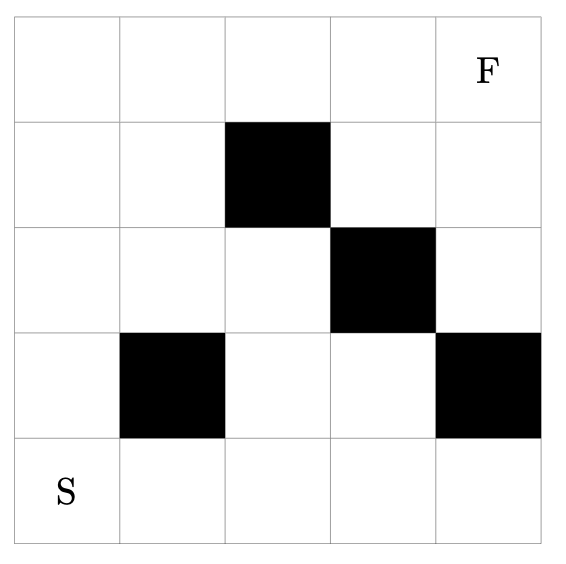

In [10]:
n_rows = 5
n_cols = 5
start = [0, 0]
end = [4, 4]
obstacles = [[1, 1], [4, 1], [3, 2], [2, 3]]

------ Graph: Graph ------
Width: 5	Height: 5
------ Grid Map Matrix ------


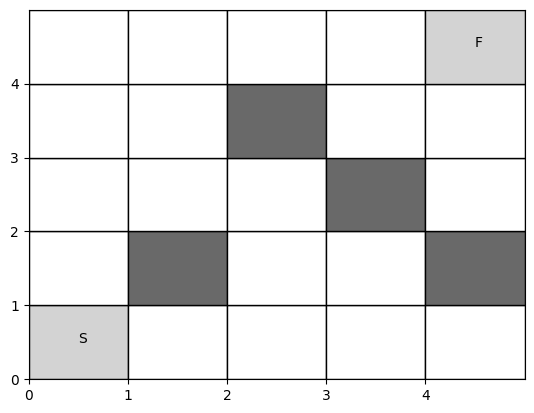

In [11]:
g = Graph(n_cols, n_rows, start, end, blocks=obstacles, name='Graph')
ax = g.show(True)


choose point [0, 0], with lowest heuristic value 14.0
add node (1, 0) to open list, heuristic value is 1.0 + 1 + 7 + 3 + 1.0= 13.0
add node (0, 1) to open list, heuristic value is 1.0 + 1 + 7 + 2 + 1.0= 12.0
choose point [0, 1], with lowest heuristic value 12.0, parent is [0, 0]
add node (0, 2) to open list, heuristic value is 1.0 + 2 + 6 + 1 + 1.0= 11.0
choose point [0, 2], with lowest heuristic value 11.0, parent is [0, 1]
add node (1, 2) to open list, heuristic value is 1.0 + 3 + 5 + 1 + 1.0= 11.0
add node (0, 3) to open list, heuristic value is 1.0 + 3 + 5 + 0 + 1.0= 10.0
choose point [0, 3], with lowest heuristic value 10.0, parent is [0, 2]
add node (1, 3) to open list, heuristic value is 1.0 + 4 + 4 + 0 + 1.0= 10.0
add node (0, 4) to open list, heuristic value is 1.0 + 4 + 4 + 0 + 1.0= 10.0
choose point [1, 3], with lowest heuristic value 10.0, parent is [0, 3]
add node (1, 4) to open list, heuristic value is 1.0 + 5 + 3 + 0 + 1.0= 10.0
choose point [1, 4], with lowest heuristic

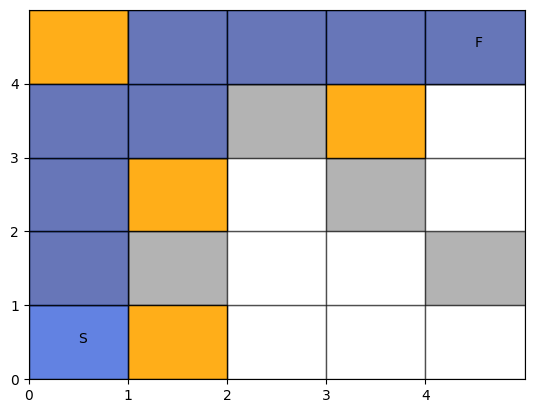

In [12]:
a_star = AStar(g, True)
path = a_star.run_without_waypoints(save_step_fig=True, declare=True)
plt.show()

### 2. With Waypoints
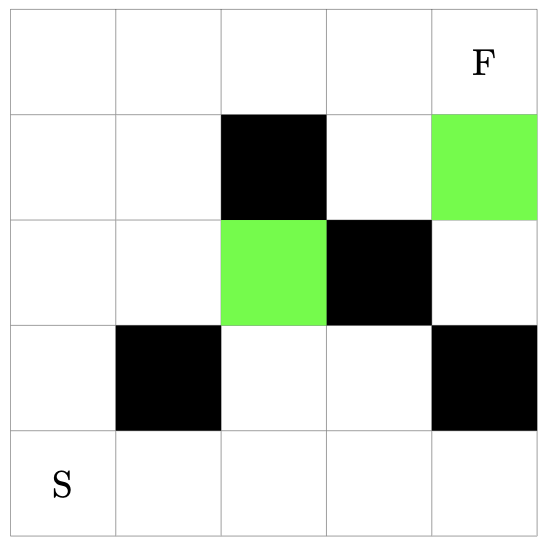


In [13]:
waypoints = [[2, 2], [4, 3]]

Begin to find the path from [0, 0] to [2, 2]
The chosen path is: 
(0, 0) => (1, 0) => (2, 0) => (2, 1) => (2, 2)
reached the point [2, 2]
Begin to find the path from [2, 2] to [4, 3]
The chosen path is: 
(2, 2) => (1, 2) => (1, 3) => (1, 4) => (2, 4) => (3, 4) => (3, 3) => (4, 3)
reached the point [4, 3]
The chosen path is: 
(4, 3) => (4, 4)


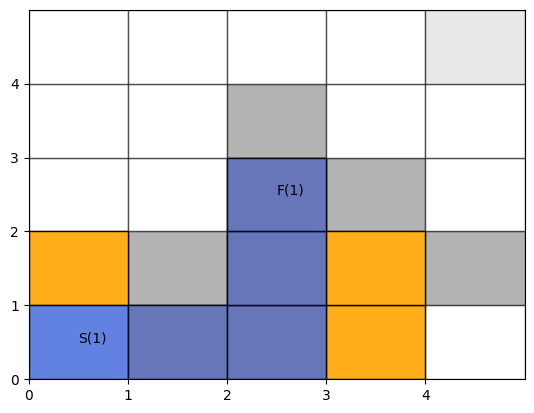

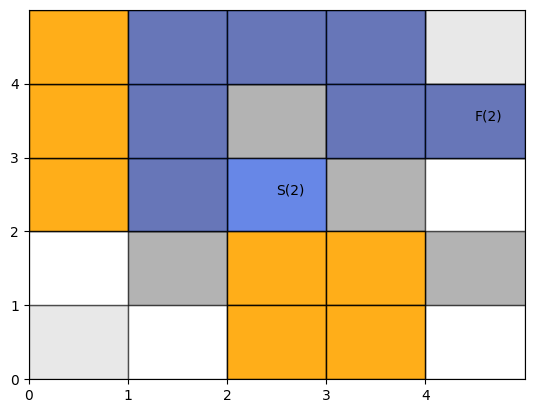

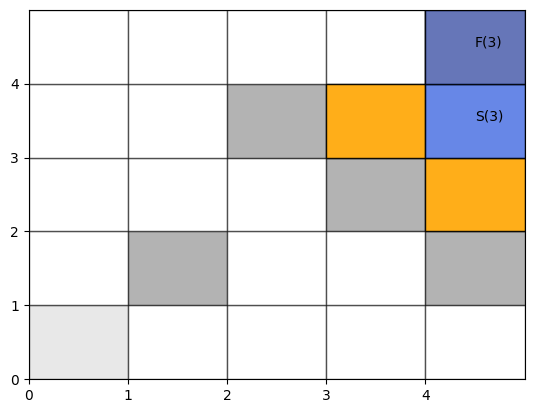

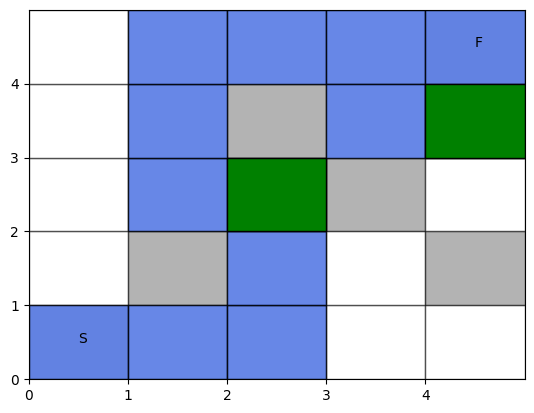

===== Algorithm finish in 12  seconds


<Figure size 640x480 with 0 Axes>

In [14]:
waypoints_A_star = AStar(g, True)
path = waypoints_A_star.run_with_waypoints(waypoints, declare=False)
plt.show()

### 3. With Varying Terrain

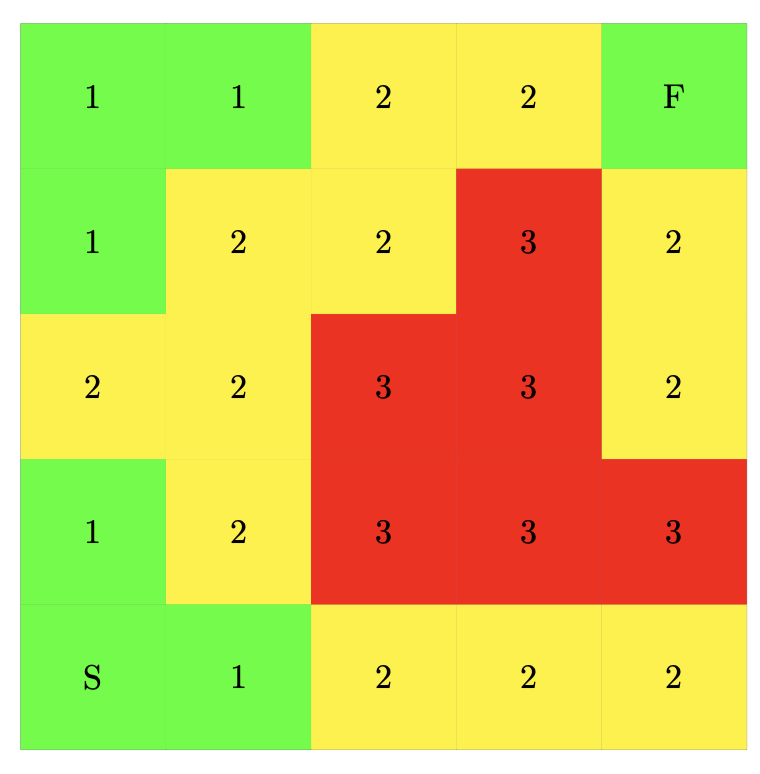

In [16]:
weights = [
    [0, 1, 2, 1, 1],
    [1, 2, 2, 2, 1],
    [2, 3, 3, 2, 2],
    [2, 3, 3, 3, 2],
    [2, 3, 2, 2, 0]
]

------ Graph: Untitled0 ------
Width: 5	Height: 5
------ Grid Map Matrix ------


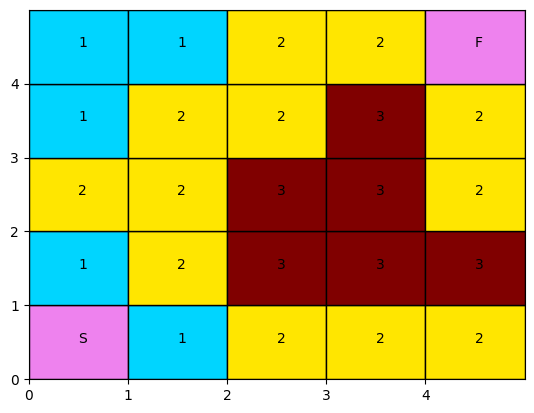

In [25]:
wg = WeightedGraph(n_cols, n_rows, weights, blocks=[])
axw = wg.show(True)

The chosen path is: 
(0, 0) => (0, 1) => (0, 2) => (0, 3) => (0, 4) => (1, 4) => (2, 4) => (3, 4) => (4, 4)
===== Algorithm finish in 5  seconds


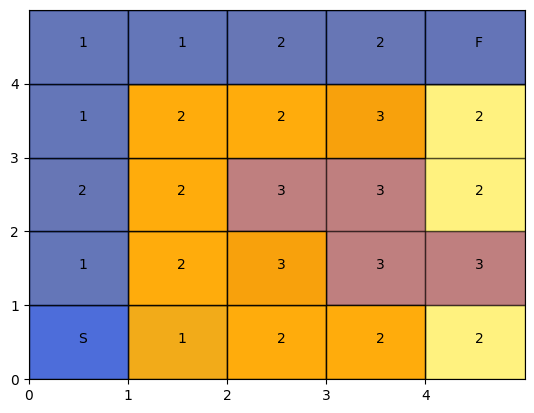

In [26]:
weighted_a_star = AStar(wg, True)
path = weighted_a_star.run_without_waypoints(declare=False)
plt.show()